# Hermaphrodite Masking

This notebook generates an approximate truth to train a Neural Network to mask out the Hermaphrodite. It also prepares data for Neural Network training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spat
import warnings
warnings.filterwarnings("error")

We import the red channel, which contains most visible neurons but also the Hermaphrodite. Please change this part to appropriate data. Note that the first dimension of the segmented data is a list and not a np array since the number of identified neurons changes frame to frame.

Desired format:

Video shape: (3002, 290, 190, 18) (timeslices,x,y,z)

Segmented data shape: (3002, Number of identified neurons, 4(for x,y,z,label))

In [2]:
allimagesr=np.load("./data/raw/allimages-r-184.npy")#This is the raw video
pointdat=np.load("./data/raw/Pointdat-184.npy",allow_pickle=True)#This is segmented data
print("Video shape:",allimagesr.shape,"(timeslices,x,y,z)")
print("Segmented data shape: ("+str(len(pointdat))+", Number of identified neurons, 4(for x,y,z,label))")

Video shape: (3002, 290, 190, 18) (timeslices,x,y,z)
Segmented data shape: (3002,Number of identified neurons,4(for x,y,z,label))


Display one random frame projected in x,y. We are going to train the network in x,y since it has almost all the information.

In [7]:
t=np.random.randint(0,3002)

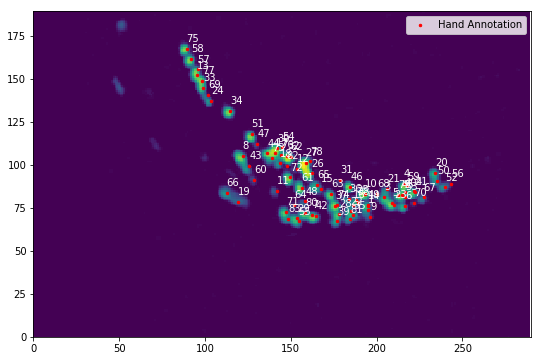

In [10]:
fig=plt.figure(figsize=(10,6))
plt.imshow(np.log(np.mean(allimagesr[t],axis=2)+1).T,origin="below")
if len(pointdat[t])!=0:
    plt.scatter(*pointdat[t][:,:2].T,c="r",s=6,label="Hand Annotation")
    for i,pt in enumerate(pointdat[t]):
        plt.annotate(int(pt[3]),pt[:2]+np.array([0,4]),color="white")
plt.xlim(0,290)
plt.ylim(0,190)
plt.legend()

There are many ways to infer if a pixel is in the male or outside from the hand annotated data.

Ex: Convex Hull with curvature constraint, 2nd order worm model fit, etc.
    
Here:

1) We manually find some neurons tags to fit the top of the body and the bottom of the body.

2) We simply identify all pixels close to any hand annotations

### Two Fit method t=564 is a good example here

In [11]:
t=564#np.random.randint(0,3002)

In [12]:
top=[75,78,34,51,30,54,78,59,4,20]
bottom=[66,19,71,83,42,9,6,67,52,55,49,28,5]
toplist=[]
bottomlist=[]
for pt in pointdat[t]:
    if int(pt[3]) in top:
        toplist.append(pt[:2])
    if int(pt[3]) in bottom:
        bottomlist.append(pt[:2])
toplist=np.array(toplist)
bottomlist=np.array(bottomlist)
coefft=np.polyfit(toplist[:,0],toplist[:,1],2)
coeffb=np.polyfit(bottomlist[:,0],bottomlist[:,1],2)
xs=np.linspace(0,290,290)

(0, 190)

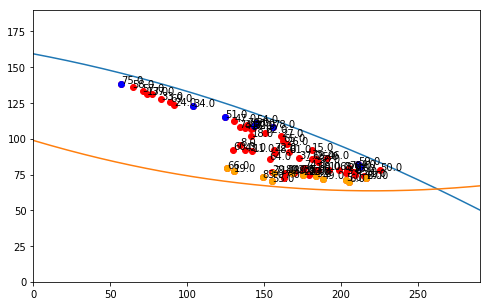

In [13]:
fig=plt.figure(figsize=(8,5))
plt.scatter(*pointdat[t][:,:2].T,c="r")
for i,pt in enumerate(pointdat[t]):
    plt.annotate(pt[3],pt[:2])
#plt.plot(xs,coefft[0]*xs**3+coefft[1]*xs**2+coefft[2]*xs+coefft[3])
#plt.plot(xs,coeffb[0]*xs**3+coeffb[1]*xs**2+coeffb[2]*xs+coeffb[3])
plt.scatter(*toplist.T,c="b")
plt.scatter(*bottomlist.T,c="orange")
plt.plot(xs,coefft[0]*xs**2+coefft[1]*xs+coefft[2]+8)
plt.plot(xs,coeffb[0]*xs**2+coeffb[1]*xs+coeffb[2]-8)
plt.xlim(0,290)
plt.ylim(0,190)

Sometimes it looks good, sometimes not

Below is a code to perform it on all time frames and generate in a binary image format: 1 for in male 0 for out of male.

In [ ]:
alltags=[]
top=[75,78,34,51,30,54,78,59,4,20]
bottom=[66,19,71,83,42,9,6,67,52,55,49,28,5]
y,x=np.meshgrid(np.linspace(0.5,allimagesr.shape[2]-0.5,allimagesr.shape[2])
                ,np.linspace(0.5,allimagesr.shape[1]-9.5,allimagesr.shape[1]))
#The image is made from this meshgrid.
for t in range(allimagesr.shape[0]):
    print("\r "+str(t),end="")
    try:
        toplist=[]
        bottomlist=[]
        for pt in pointdat[t]:
            if int(pt[3]) in top:
                toplist.append(pt[:2])
            if int(pt[3]) in bottom:
                bottomlist.append(pt[:2])
        toplist=np.array(toplist)
        bottomlist=np.array(bottomlist)
        if len(toplist)<5 or len(toplist)<5:
            alltags.append(0)
            continue
        coefft=np.polyfit(toplist[:,0],toplist[:,1],2)
        coeffb=np.polyfit(bottomlist[:,0],bottomlist[:,1],2)
        head=np.max(pointdat[t][:,0])#This truncates the worm at some x: very hand-coded
        arr=(y<coefft[0]*x**2+coefft[1]*x+coefft[2]+8)&(y>coeffb[0]*x**2+coeffb[1]*x+coeffb[2]-8)&(x<head+8)
        alltags.append(arr)
    except:#Fitting errors, etc
        alltags.append(0)

We save only the succesful ones and their corredponding images. These are the training data and labels.

In [ ]:
finetags=[]
fineims=[]
for tags,im in zip(alltags,allimagesr):
    if type(tags)!=int:
        finetags.append(tags)
        fineims.append(np.mean(im,axis=2))
finetags=np.array(finetags)
fineims=np.array(fineims)

In [ ]:
np.save("./herm-tags.npy",finetags)
np.save("./herm-ims.npy",fineims)

### Near distance method

The threshold should be appropriate:

Here, Distance_Threshold=9

In [15]:
######
Distance_Threshold=9
######
y,x=np.meshgrid(np.linspace(0.5,allimagesr.shape[2]-0.5,allimagesr.shape[2])
                ,np.linspace(0.5,allimagesr.shape[1]-9.5,allimagesr.shape[1]))
queryarr=np.array([x,y]).swapaxes(0,2).swapaxes(0,1).reshape(allimagesr.shape[2]*allimagesr.shape[1],2)
#queryarr is here to query all coordinates of the image
def bin(pts):
    tree=spat.cKDTree(pts)
    return (tree.query(queryarr)[0]<Distance_Threshold).reshape(290,190)

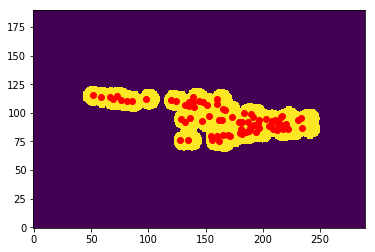

In [16]:
#random frame, if there is no detected peaks, this will report and error
t=np.random.randint(0,3002)
plt.imshow(bin(pointdat[t][:,:2]).T,origin="below")
plt.scatter(*pointdat[t][:,:2].T,c="r")

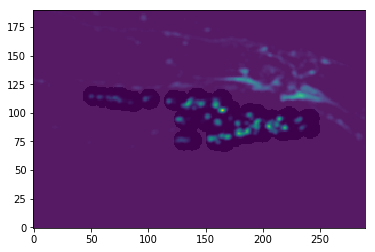

In [17]:
plt.imshow(np.mean(allimagesr[t],axis=2).T,origin="below")
plt.imshow(bin(pointdat[t][:,:2]).T,origin="below",cmap="binary",alpha=0.1)

In [4]:
alltags=[]
for t in range(3002):
    print("\r "+str(t),end="")
    try:
        alltags.append(bin(pointdat[t][:,:2]))
    except:
        alltags.append(0)

 3001

Save only the good ones

In [8]:
finetags=[]
fineims=[]
for tags,im in zip(alltags,allimagesr):
    if type(tags)!=int:
        finetags.append(tags)
        fineims.append(np.mean(im,axis=2))
finetags=np.array(finetags)
fineims=np.array(fineims)

In [11]:
np.save("./herm-tags.npy",finetags)
np.save("./herm-ims.npy",fineims)